# The Future is Now: Patterns in Global Temperature Trends Across the World

Continued from `Analysis 1.ipynb`.

## Dependency Installation & Imports

In [1]:
%pip install pandas numpy scikit-learn matplotlib missingno pyarrow pycountry_convert kgcpy scipy fastdtw statsmodels networkx pyvis

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import euclidean, cityblock
from fastdtw import fastdtw
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

In [3]:
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', 12)

In [4]:
global_correlation = 0.8770524844965029

In [5]:
with open('Data_augmented.csv', 'r') as file:
    df = pd.read_csv(file)

df = df.drop(['Latitude', 'Longitude', 'AbsLatitude', 'AbsLongitude'], axis=1)

df.head()

,City,Year,AverageTemperature,Country,NumericLatitude,NumericLongitude,Continent,kcc
0,Abidjan,1880,25.957083,Cote D'Ivoire,5.63,-3.23,Africa,Aw
1,Abidjan,1881,26.073333,Cote D'Ivoire,5.63,-3.23,Africa,Aw
2,Abidjan,1882,25.687167,Cote D'Ivoire,5.63,-3.23,Africa,Aw
3,Abidjan,1883,26.131333,Cote D'Ivoire,5.63,-3.23,Africa,Aw
4,Abidjan,1884,26.366625,Cote D'Ivoire,5.63,-3.23,Africa,Aw


In [6]:
df.describe()

,Year,AverageTemperature,NumericLatitude,NumericLongitude
count,13380.000000,13380.000000,13380.000000,13380.000000
mean,1946.592302,18.923682,20.101975,45.565155
std,38.637778,7.265445,22.360693,65.772809
min,1880.000000,1.317000,-37.780000,-118.700000
25%,1913.000000,12.491375,7.230000,8.220000
50%,1947.000000,20.600125,24.920000,46.110000
75%,1980.000000,25.706750,36.170000,106.550000
max,2013.000000,30.730167,60.270000,151.780000


## Further Pattern Examination

Multidimensional Scaling (MDS) and Hierarchical Clustering

1. Create normalized City profiles based on Year and Average Temperature
2. Calculate Euclidean distances, visualize with heatmap
3. Calculate Dynamic Time Warping (DTW) distances, visualize with heatmap
   * Apply Multi-Dimensional Scaling (MDS) to form a 2D space, visualize with scatter plot - find cities with similar climates
   * Apply Hierarchical Clustering (group cities based on temperature profile similarities), visualize with dendrogram - show how cities can be grouped based on temperature profiles

In [7]:
# Create a temperature profile for each city
city_profiles = df.pivot(index='Year', columns='City', values='AverageTemperature').ffill().bfill()

# Normalize with z-scores
city_profiles_standardized = (city_profiles - city_profiles.mean()) / city_profiles.std()

for city in city_profiles_standardized:
    assert city_profiles_standardized[city].values.ndim == 1, f"{city} profile is not 1-D"

# Euclidean distances between all city pairs
distances_euclid = pdist(city_profiles_standardized.transpose(), metric='euclidean')

# condensed distance matrix -> square
matrix_euclid = squareform(distances_euclid)

# DTW distance matrix
cities = city_profiles_standardized.columns
num_cities = len(cities)
matrix_dtw = np.zeros((num_cities, num_cities))

# Inputs need to be 1 dimensional
def euclidean_distance_wrapper(x, y):
    x_flat = np.array(x).flatten()
    y_flat = np.array(y).flatten()
    return euclidean(x_flat, y_flat)

for i in range(num_cities):
    # Only need upper triangle since it will be symmetrical about the diagonal
    for j in range(i + 1, num_cities):
        city1, city2 = cities[i], cities[j]
        distance, _ = fastdtw(city_profiles_standardized[city1].values, city_profiles_standardized[city2].values, dist=euclidean_distance_wrapper)
        # Make it symmetrical
        matrix_dtw[i, j] = distance
        matrix_dtw[j, i] = distance
        
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
matrix_cities = mds.fit_transform(matrix_dtw)

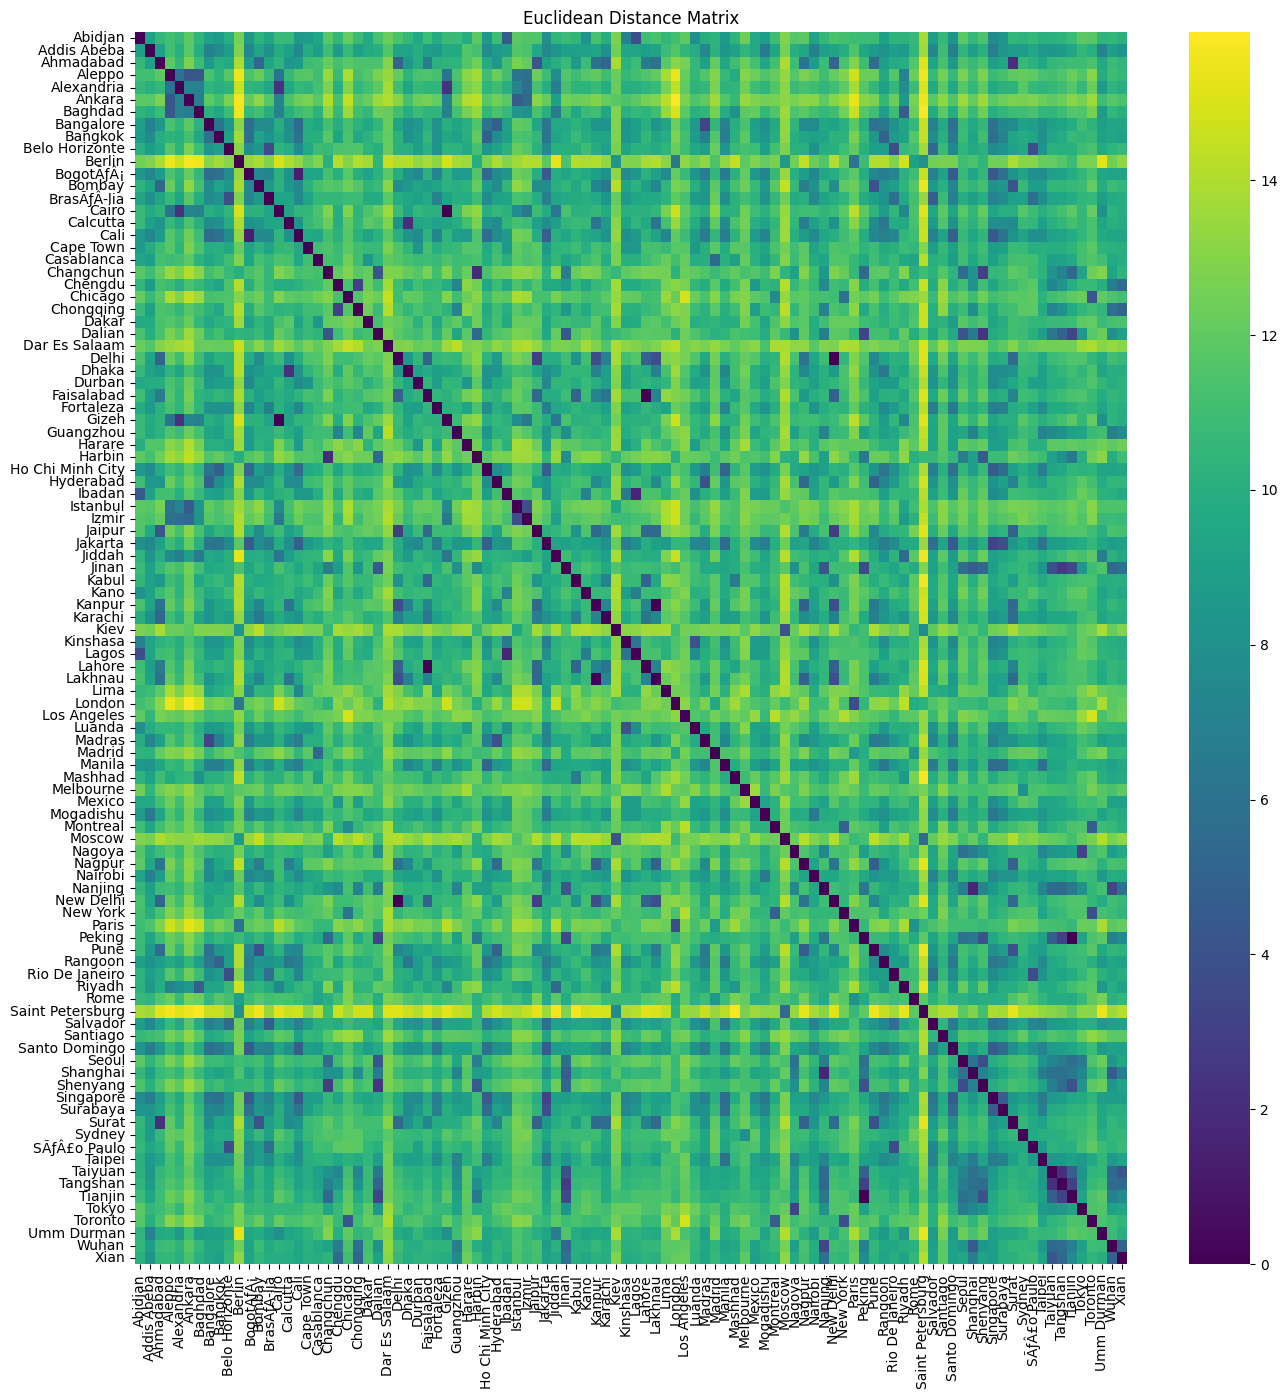

In [8]:
# Visualize Euclidean distance matrix
plt.figure(figsize=(16, 16))
sns.heatmap(matrix_euclid, xticklabels=cities, yticklabels=cities, cmap='viridis')
plt.title('Euclidean Distance Matrix')
plt.show()

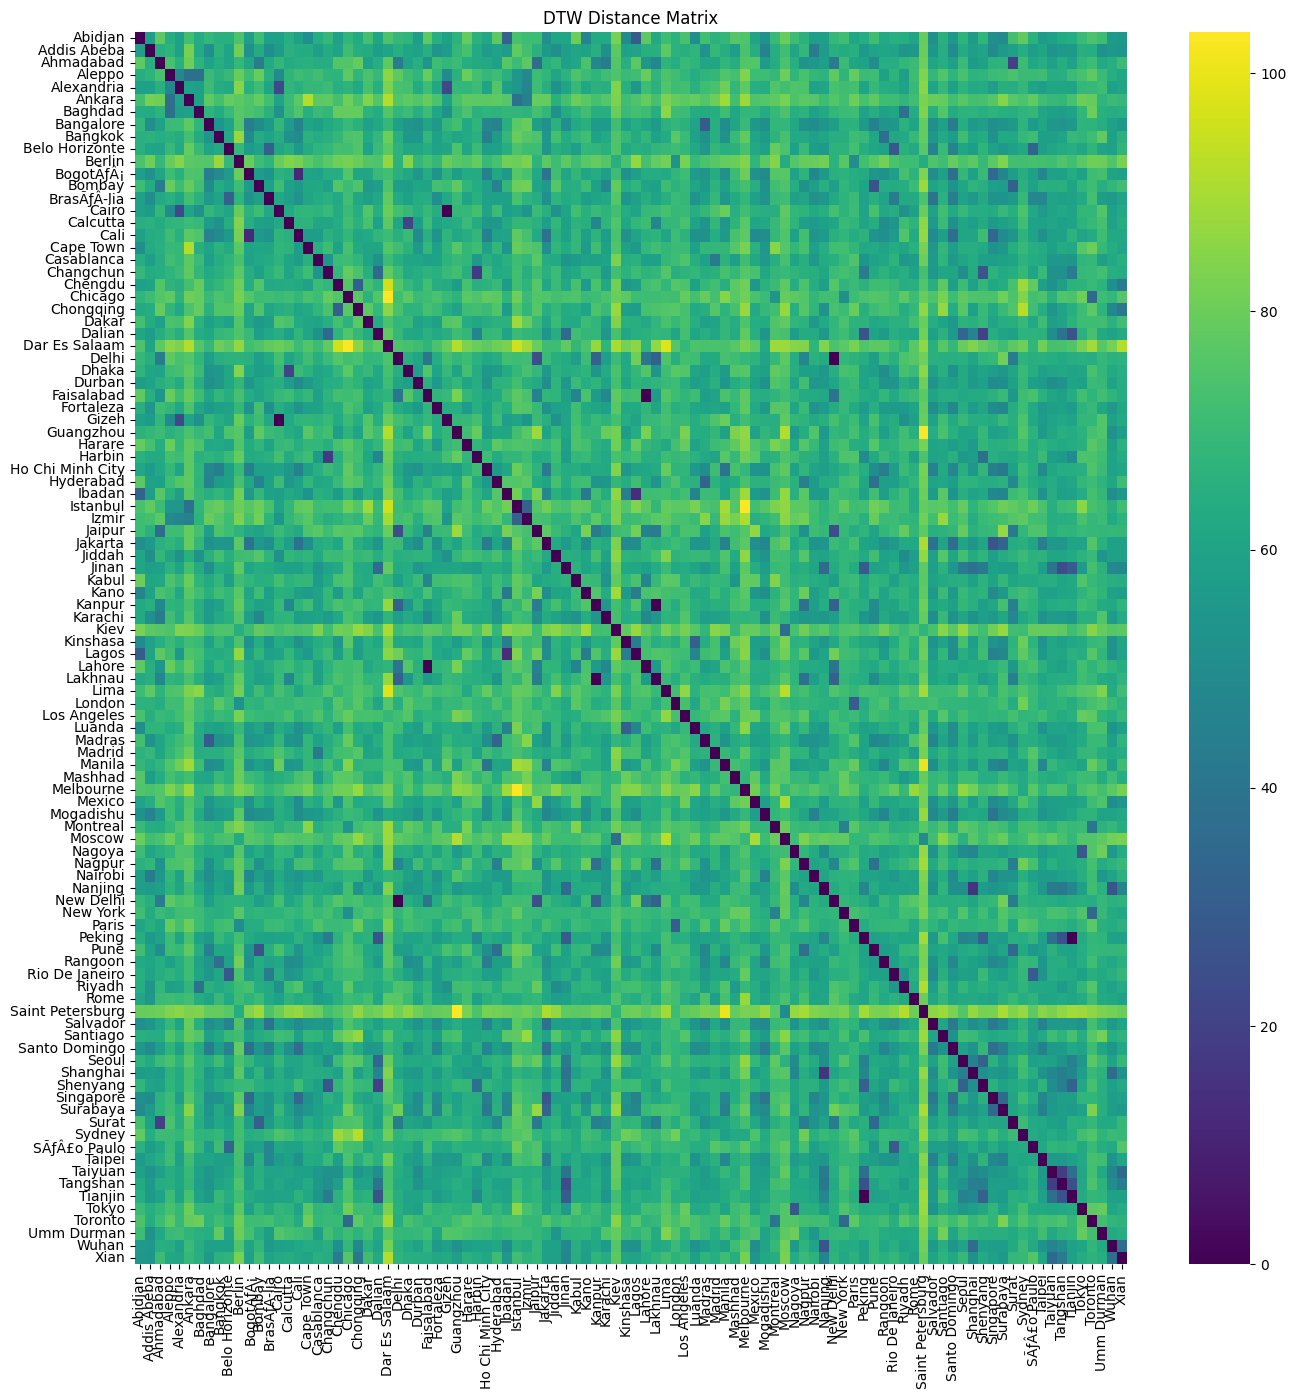

In [9]:
# Visualize DTW distance matrix
plt.figure(figsize=(16, 16))
sns.heatmap(matrix_dtw, xticklabels=cities, yticklabels=cities, cmap='viridis')
plt.title('DTW Distance Matrix')
plt.show()

In [10]:
# Find most strongly correlated city pairs for Euclidean & DTW matrices
def find_strongly_correlated_city_pairs(distance_matrix, cities, percentile=2.5):
    # Remove self distances
    distances = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
    
    # Threshold for top {percentile}
    threshold = np.percentile(distances, percentile)

    strong_pair_indices = np.where((distance_matrix <= threshold) & (distance_matrix > 0))
    strong_pairs = sorted([(min(cities[i], cities[j]), max(cities[i], cities[j]), distance_matrix[i, j])
                           for i, j in zip(*strong_pair_indices)], key=lambda x: (x[0], x[1]))
    
    return strong_pairs, threshold

strong_pairs_euclid, thres_euclid = find_strongly_correlated_city_pairs(matrix_euclid, cities)
strong_pairs_dtw, thres_dtw = find_strongly_correlated_city_pairs(matrix_dtw, cities)

# Make a set out of the strongest pairs from both euclidian and dtw distance matrices
strong_pairs_merged = set(strong_pairs_euclid + strong_pairs_dtw)

for pair in sorted(strong_pairs_merged, key=lambda x: x[2]):
    print(f"{pair[0]} and {pair[1]} have a strong correlation with a distance of {pair[2]:.2f}")

BogotÃƒÂ¡ and Cali have a strong correlation with a distance of 1.33
Ibadan and Lagos have a strong correlation with a distance of 1.69
Nanjing and Shanghai have a strong correlation with a distance of 1.73
Changchun and Harbin have a strong correlation with a distance of 1.91
Ahmadabad and Surat have a strong correlation with a distance of 2.14
Taiyuan and Tangshan have a strong correlation with a distance of 2.18
Calcutta and Dhaka have a strong correlation with a distance of 2.23
Alexandria and Cairo have a strong correlation with a distance of 2.24
Alexandria and Gizeh have a strong correlation with a distance of 2.24
Dalian and Shenyang have a strong correlation with a distance of 2.37
Jinan and Tangshan have a strong correlation with a distance of 2.64
Delhi and Jaipur have a strong correlation with a distance of 2.84
Jaipur and New Delhi have a strong correlation with a distance of 2.84
Changchun and Shenyang have a strong correlation with a distance of 2.98
Chengdu and Chongqin

Visualize the strongest correlations as an interactive network graph (easier to read)
- Not the same as clustering but we should see cities that have similar AverageTemperatures close to each other on the graph.
  - We expect at least some of these to be cities to be geographically close (expected but not really an interesting pattern)

In [11]:
from pyvis.network import Network

city_labels = df.drop_duplicates(subset=['City']).set_index('City').apply(
    lambda row: f"{row.name}, {row['Country']}, {row['kcc']}", axis=1).to_dict()

# Initialize a new PyVis network
net = Network(notebook=True, height="700px", width="100%", cdn_resources='remote')
net.barnes_hut()

node_size = 30
font_size = 30

for city1, city2, dist in strong_pairs_merged:
    label1 = city_labels.get(city1, city1)
    label2 = city_labels.get(city2, city2)
    if city1 not in net.get_nodes():
        net.add_node(city1, title=label1, label=label1, size=node_size)
    if city2 not in net.get_nodes():
        net.add_node(city2, title=label2, label=label2, size=node_size)
    net.add_edge(city1, city2, title=f"Distance: {dist:.2f}", value=2)

options = """
{
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -8000,
      "centralGravity": 0.3,
      "springLength": 100,
      "springConstant": 0.04,
      "damping": 0.09,
      "avoidOverlap": 0.9
    },
    "minVelocity": 0.75,
    "solver": "barnesHut"
  },
  "nodes": {
    "font": {
      "size": 30
    }
  }
}
"""

net.set_options(options)

net.show("network.html")


network.html


// Summary

**Interpretation of strongly-associated cities**

Most of these groupings are geographically close to each other, so not particularly noteworthy.

### Clustering

1. Try to find optimal number of clusters for k-means by using silhouette score and elbow method.
2. Perform k-means clustering with apparently optimal number of clusters, visualize them.

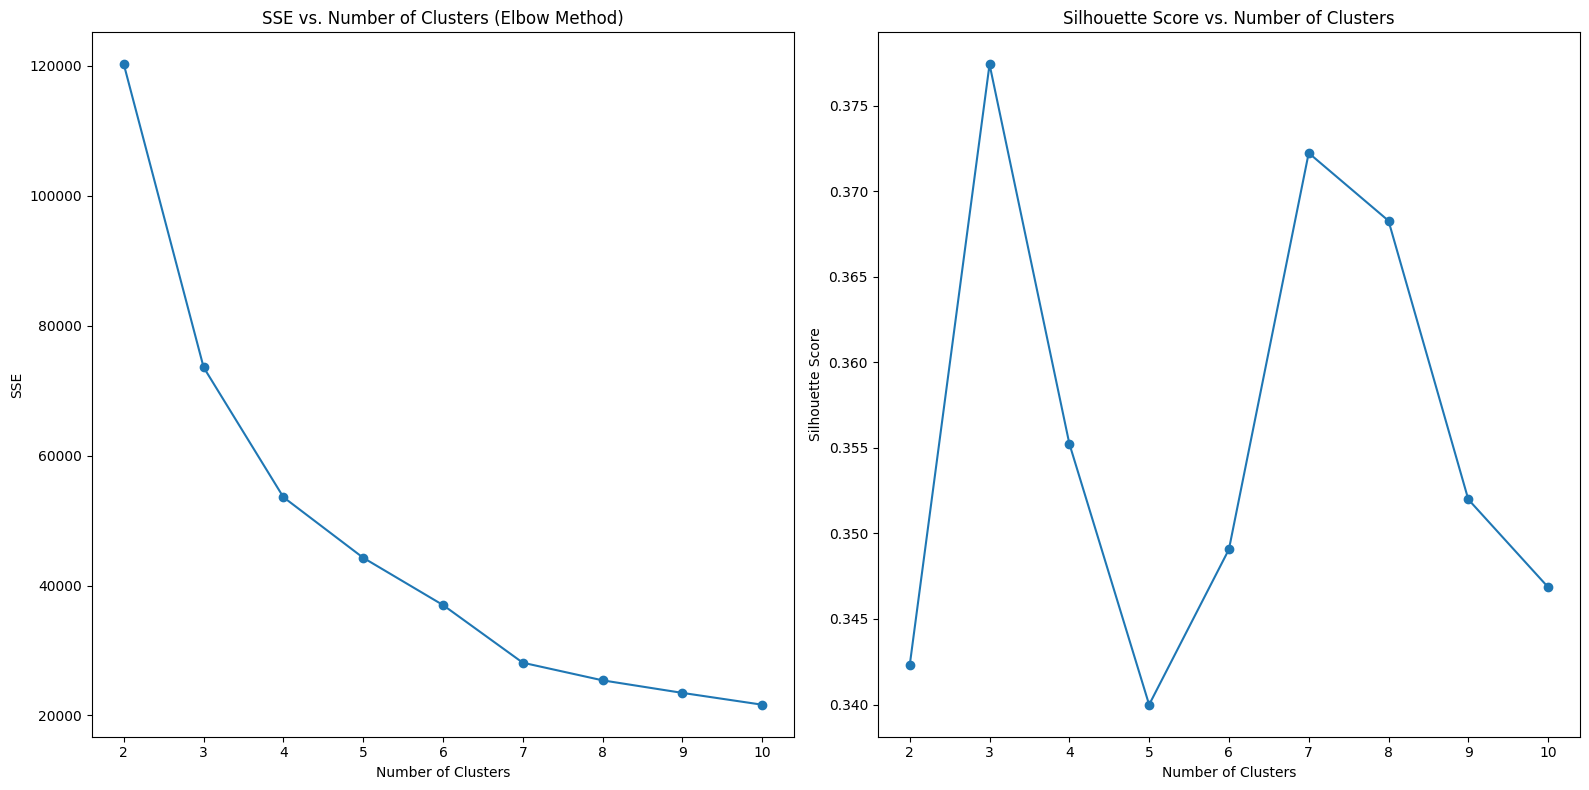

In [12]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

cluster_range = range(2, 11)
silhouette_scores = []
sse_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(matrix_cities)
    
    silhouette_avg = silhouette_score(matrix_cities, labels)
    silhouette_scores.append(silhouette_avg)
    sse_scores.append(kmeans.inertia_)
    
plt.figure(figsize=(16, 8))

# Elbow Method graph
plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse_scores, marker='o')
plt.title('SSE vs. Number of Clusters (Elbow Method)')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

# Silhouette score graph
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

For the elbow method it looks like 3 or 4 clusters is ideal, and going by silhouette score it peaks at 3 clusters, so we'll do k-means clustering with k=3.

In [13]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(matrix_cities)

silhouette_avg = silhouette_score(matrix_cities, labels)
print(f"Silhouette Score for 3 clusters: {silhouette_avg:.2f}")


Silhouette Score for 3 clusters: 0.38


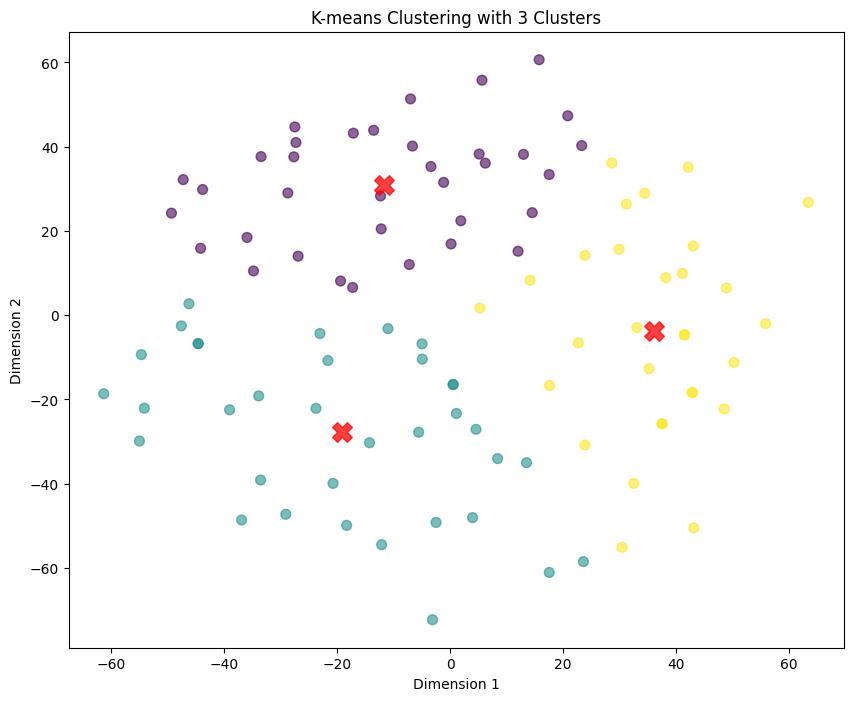

In [14]:
plt.figure(figsize=(10, 8))
plt.scatter(matrix_cities[:, 0], matrix_cities[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('K-means Clustering with 3 Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [15]:
city_names = df['City'].drop_duplicates(keep='first').tolist()
city_clusters = {city: label for city, label in zip(city_names, labels)}

# Mapping w/ city info
city_info = df.drop_duplicates(subset='City', keep='first').set_index('City')[['Country', 'NumericLatitude', 'NumericLongitude', 'Continent', 'kcc']]

clustered_data = []

for city, cluster_label in city_clusters.items():
    info = city_info.loc[city].to_dict()
    info['City'] = city
    info['Cluster'] = cluster_label
    clustered_data.append(info)

df_kmeans = pd.DataFrame(clustered_data)

df_kmeans = df_kmeans.sort_values(by=['Cluster', 'City']).reset_index(drop=True)

outfile = 'Data_kmeans.csv'
df_kmeans.to_csv(f'{outfile}', index=False)

print(f'Exported clustered cities to {outfile}')

Exported clustered cities to {outfile}


#### Cluster visualizations

1. Continent proportion in each cluster
2. Koppen climate classification (kcc) proportion in each cluster
3. Box & Whisker Plot for Latitudes, Longitudes

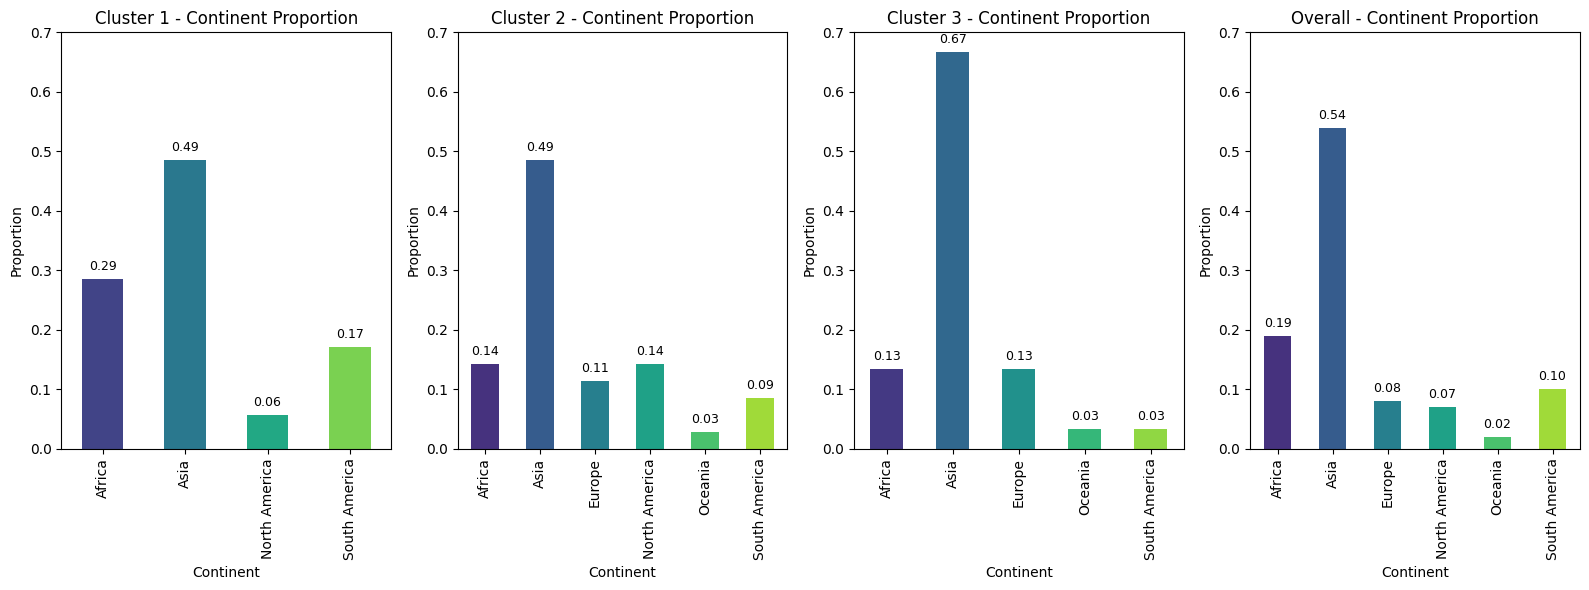

In [16]:
plt.figure(figsize=(16, 6))
num_clusters = df_kmeans['Cluster'].nunique()

for i in range(num_clusters):
    plt.subplot(1, num_clusters + 1, i+1)
    cluster_data = df_kmeans[df_kmeans['Cluster'] == i]
    continent_counts = cluster_data['Continent'].value_counts(normalize=True).sort_index()
    bars = continent_counts.plot(kind='bar', color=sns.color_palette("viridis", len(continent_counts)))
    plt.title(f'Cluster {i+1} - Continent Proportion')
    plt.ylabel('Proportion')
    plt.xlabel('Continent')
    plt.ylim(0.0, 0.70)
    for index, value in enumerate(continent_counts):
        plt.text(index, value + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=9, color='black')

# Adding a graph for the overall proportions of each continent in the dataset
plt.subplot(1, num_clusters + 1, num_clusters + 1)
overall_continent_counts = df_kmeans['Continent'].value_counts(normalize=True).sort_index()
bars = overall_continent_counts.plot(kind='bar', color=sns.color_palette("viridis", len(overall_continent_counts)))
plt.title('Overall - Continent Proportion')
plt.ylabel('Proportion')
plt.xlabel('Continent')
plt.ylim(0.0, 0.70)

for index, value in enumerate(overall_continent_counts):
    plt.text(index, value + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()


Summarizing the relative abundance of each continent in each cluster compared to the overall dataset:

Continent|Cluster 1 Δ|Cluster 2 Δ|Cluster 3 Δ|
--------:|-----------|-----------|-----------|
Africa|0.10|-0.05|-0.06
Asia|-0.05|-0.01|0.13
Europe|-0.08|0.03|0.05
North America|-0.01|0.07|-0.07
Oceania|-0.02|0.01|0.01
South America|0.07|-0.01|-0.07

Visualizing the clusters as a heatmap:

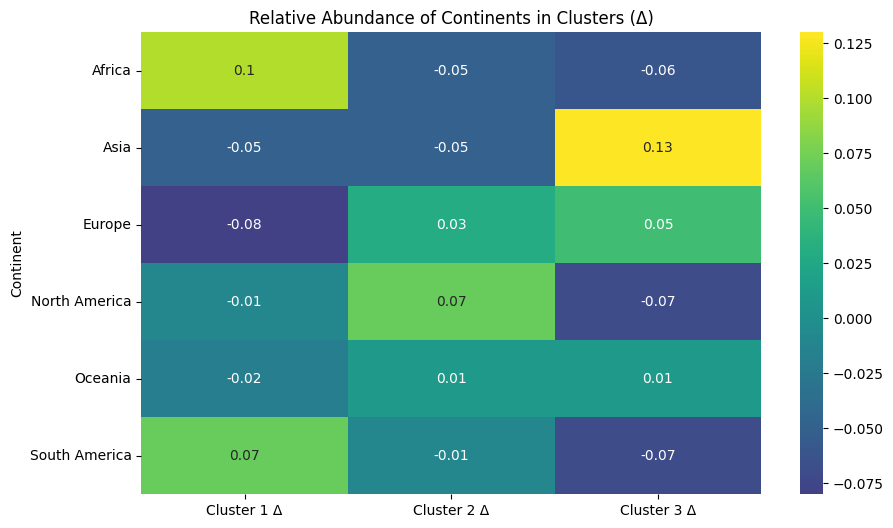

In [17]:
data = {
    'Continent': ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'],
    'Cluster 1 Δ': [0.1, -0.05, -0.08, -0.01, -0.02, 0.07],
    'Cluster 2 Δ': [-0.05, -0.05, 0.03, 0.07, 0.01, -0.01],
    'Cluster 3 Δ': [-0.06, 0.13, 0.05, -0.07, 0.01, -0.07]
}

df_deltas = pd.DataFrame(data)
df_deltas = df_deltas.set_index('Continent')

plt.figure(figsize=(10, 6))
sns.heatmap(df_deltas, annot=True, cmap="viridis", center=0)
plt.title('Relative Abundance of Continents in Clusters (Δ)')
plt.show()


Now let's see if we can find anything interesting if we graph AverageTemperature by Year for each cluster.

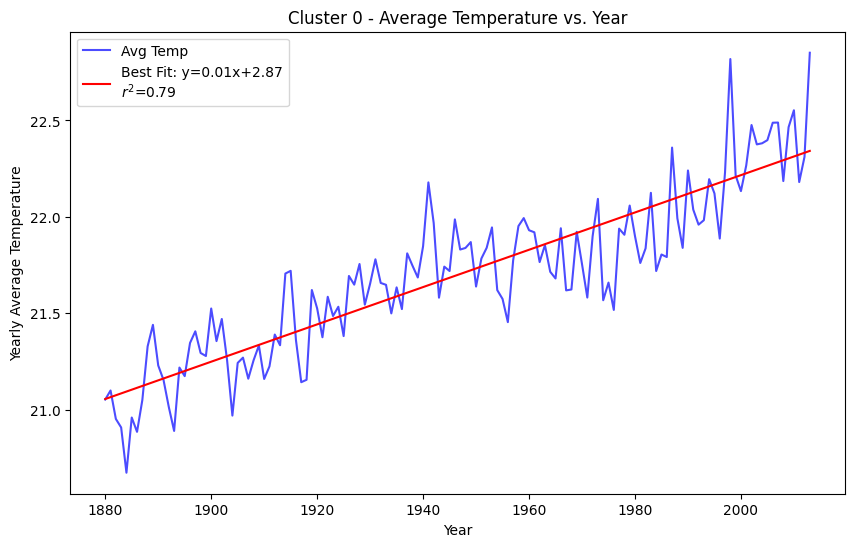

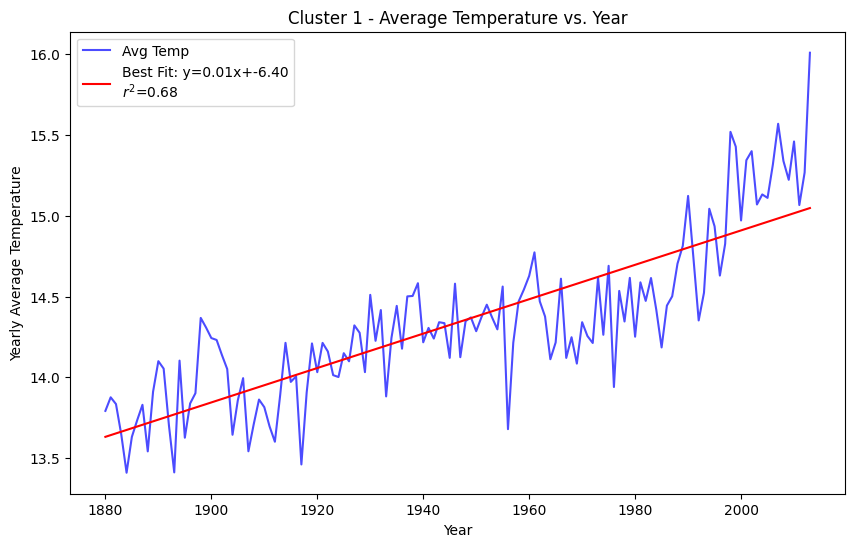

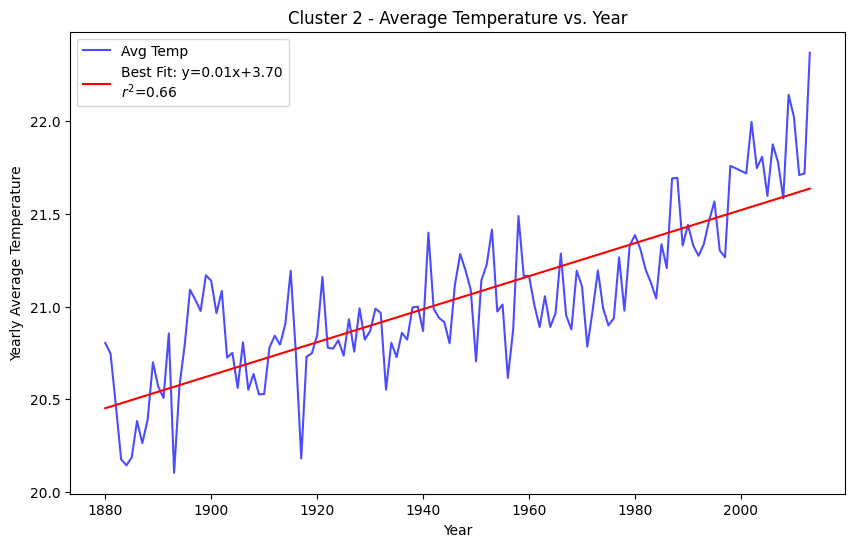

In [18]:
from scipy.stats import linregress

merged_df = pd.merge(df, df_kmeans[['City', 'Cluster']], on='City', how='left')

for cluster in range(merged_df['Cluster'].nunique()):
    plt.figure(figsize=(10, 6))
    cluster_data = merged_df[merged_df['Cluster'] == cluster]
    
    # Calculate yearly average temperatures for the filtered data
    yearly_avg_temp = cluster_data.groupby('Year')['AverageTemperature'].mean()
    
    years = yearly_avg_temp.index.values
    avg_temps = yearly_avg_temp.values
    
    plt.plot(years, avg_temps, label='Avg Temp', color='blue', alpha=0.7)
    
    # Line of best fit
    slope, intercept, r_value, p_value, std_err = linregress(years, avg_temps)
    plt.plot(years, intercept + slope*years, label=f'Best Fit: y={slope:.2f}x+{intercept:.2f}\n$r^2$={r_value**2:.2f}', color="red")
    
    plt.title(f'Cluster {cluster} - Average Temperature vs. Year')
    plt.xlabel('Year')
    plt.ylabel('Yearly Average Temperature')
    plt.legend()
    plt.show()


Now to do the same thing with climate classifications to determine if there are any interesting results:

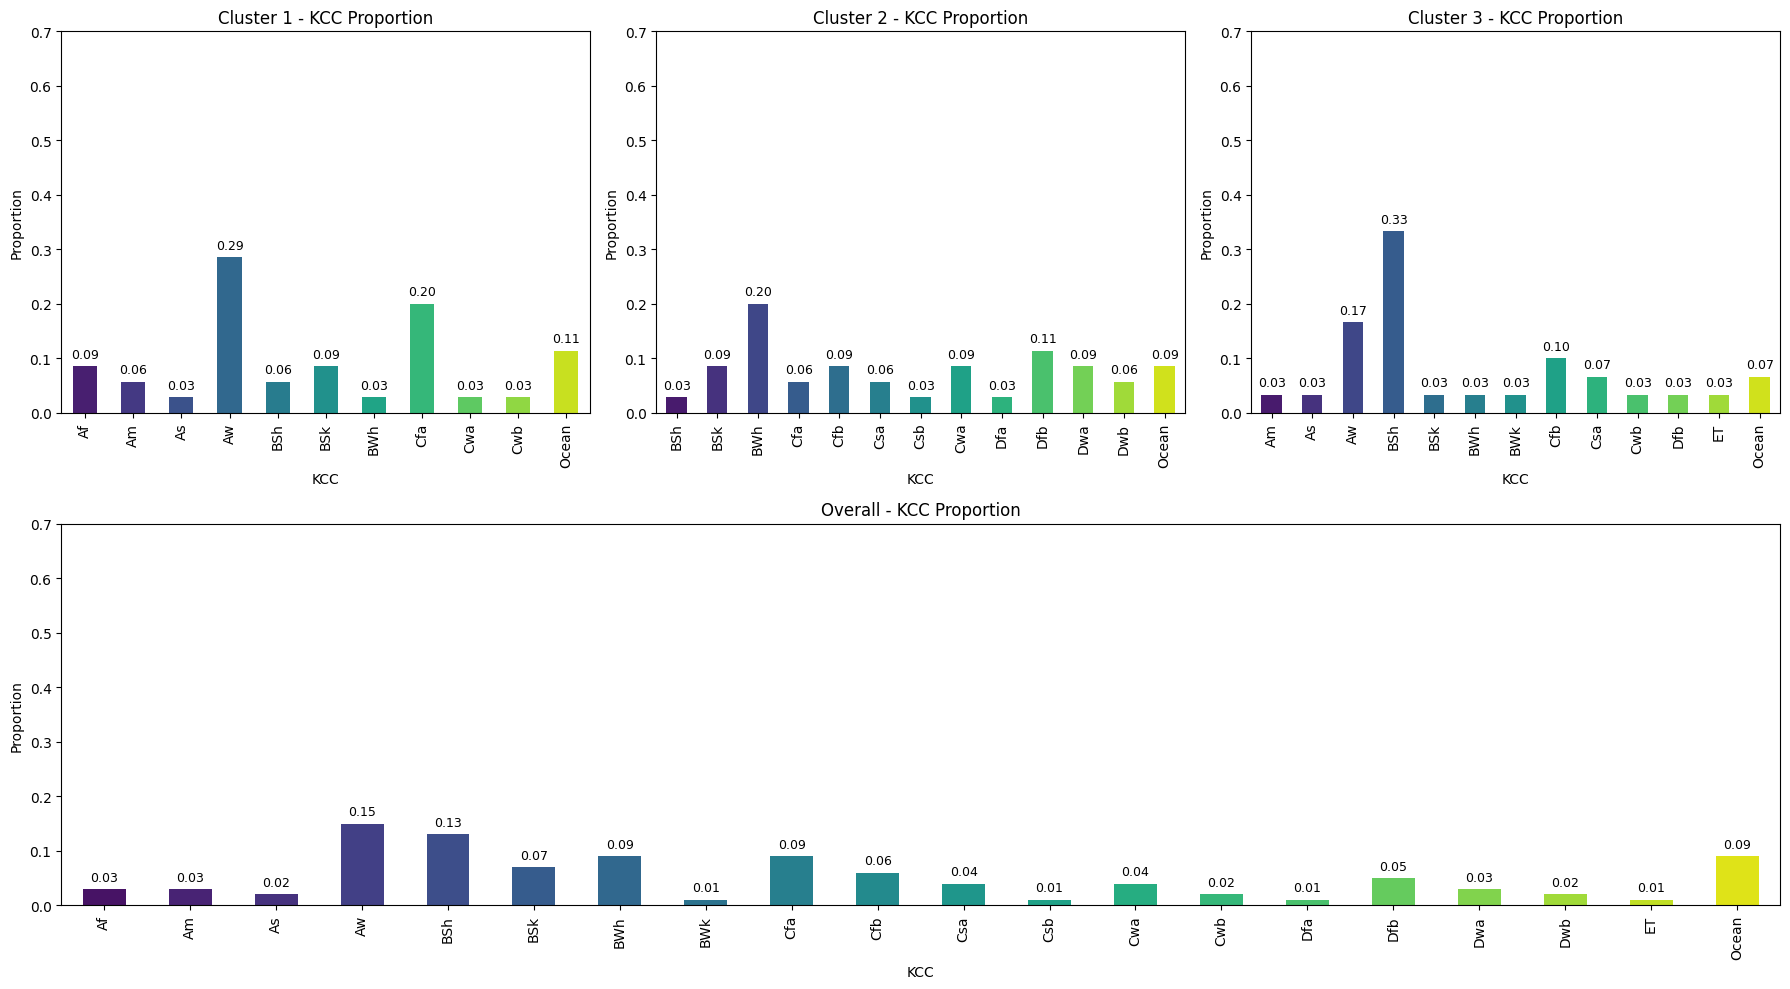

In [21]:
num_clusters = df_kmeans['Cluster'].nunique()
plt.figure(figsize=(18, 10))

for i in range(num_clusters):
    plt.subplot(2, num_clusters, i+1) 
    cluster_data = df_kmeans[df_kmeans['Cluster'] == i]
    kcc_counts = cluster_data['kcc'].value_counts(normalize=True).sort_index()
    bars = kcc_counts.plot(kind='bar', color=sns.color_palette("viridis", len(kcc_counts)))
    plt.title(f'Cluster {i+1} - KCC Proportion')
    plt.ylabel('Proportion')
    plt.xlabel('KCC')
    plt.ylim(0.0, 0.70)
    for index, value in enumerate(kcc_counts):
        plt.text(index, value + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=9, color='black')

plt.subplot(2, 1, 2)
overall_kcc_counts = df_kmeans['kcc'].value_counts(normalize=True).sort_index()
bars = overall_kcc_counts.plot(kind='bar', color=sns.color_palette("viridis", len(overall_kcc_counts)))
plt.title('Overall - KCC Proportion')
plt.ylabel('Proportion')
plt.xlabel('KCC')
plt.ylim(0.0, 0.70)
for index, value in enumerate(overall_kcc_counts):
    plt.text(index, value + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()


Summarizing the relative abundance of each climate classification in each cluster compared to the overall dataset:

Climate|Cluster 1 Δ|Cluster 2 Δ|Cluster 3 Δ|
--------:|-----------|-----------|-----------|
Af|0.06|-0.03|-0.03
Am|0.03|-0.03|0
As|0.01|-0.02|0.01
Aw|0.14|-0.15|0.02
BSh|-0.07|-0.1|0.2
BSk|0.02|0.02|-0.04
BWh|-0.06|0.11|-0.06
BWk|-0.01|-0.01|0.02
Cfa|0.11|-0.03|-0.09
Cfb|-0.06|0.03|0.04
Csa|-0.04|0.02|0.03
Csb|-0.01|0.02|-0.01
Cwa|-0.01|0.05|-0.04
Cwb|0.01|-0.02|0.01
Dfa|-0.01|0.02|-0.01
Dfb|-0.05|0.06|-0.02
Dwa|-0.03|0.06|-0.03
Dwb|-0.02|0.04|-0.02
ET|-0.01|-0.01|0.02
Ocean|0.02|0|-0.02


Visualizing the clusters as a heatmap:

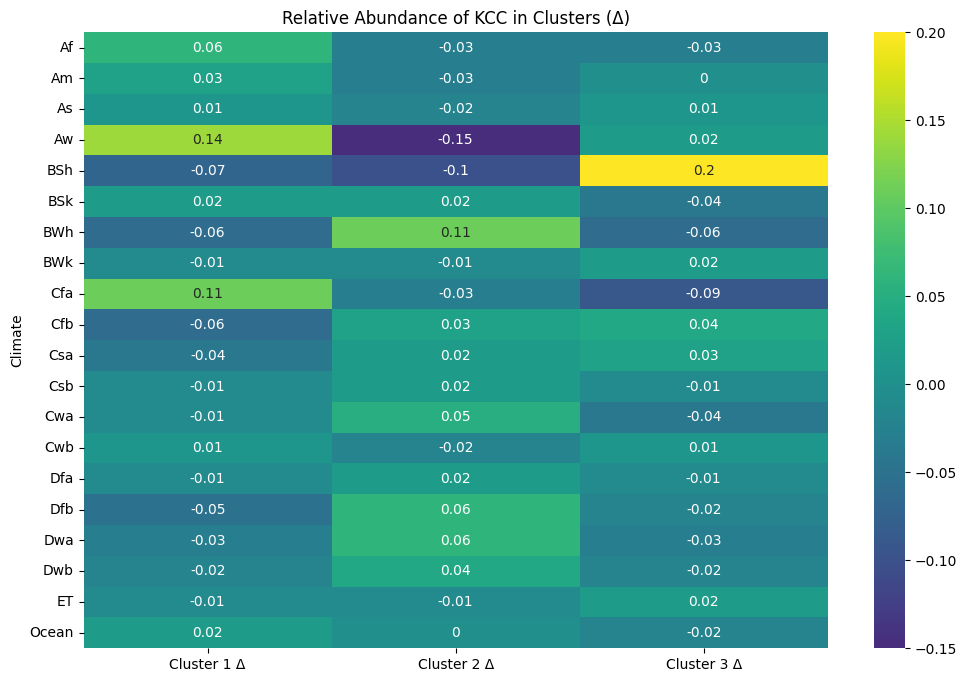

In [22]:
data = {
    'Climate': ['Af', 'Am', 'As', 'Aw', 'BSh', 'BSk', 'BWh', 'BWk', 'Cfa', 'Cfb', 'Csa', 'Csb', 'Cwa', 'Cwb', 'Dfa', 'Dfb', 'Dwa', 'Dwb', 'ET', 'Ocean'],
    'Cluster 1 Δ': [0.06, 0.03, 0.01, 0.14, -0.07, 0.02, -0.06, -0.01, 0.11, -0.06, -0.04, -0.01, -0.01, 0.01, -0.01, -0.05, -0.03, -0.02, -0.01, 0.02],
    'Cluster 2 Δ': [-0.03, -0.03, -0.02, -0.15, -0.10, 0.02, 0.11, -0.01, -0.03, 0.03, 0.02, 0.02, 0.05, -0.02, 0.02, 0.06, 0.06, 0.04, -0.01, 0],
    'Cluster 3 Δ': [-0.03, 0, 0.01, 0.02, 0.20, -0.04, -0.06, 0.02, -0.09, 0.04, 0.03, -0.01, -0.04, 0.01, -0.01, -0.02, -0.03, -0.02, 0.02, -0.02]
}

df_deltas = pd.DataFrame(data)
df_deltas = df_deltas.set_index('Climate')  # Setting 'Climate' as the index for heatmap

plt.figure(figsize=(12, 8))  # Adjusted for readability
sns.heatmap(df_deltas, annot=True, cmap="viridis", center=0)
plt.title('Relative Abundance of KCC in Clusters (Δ)')
plt.show()

Now lets see how geographically spread our clusters are:

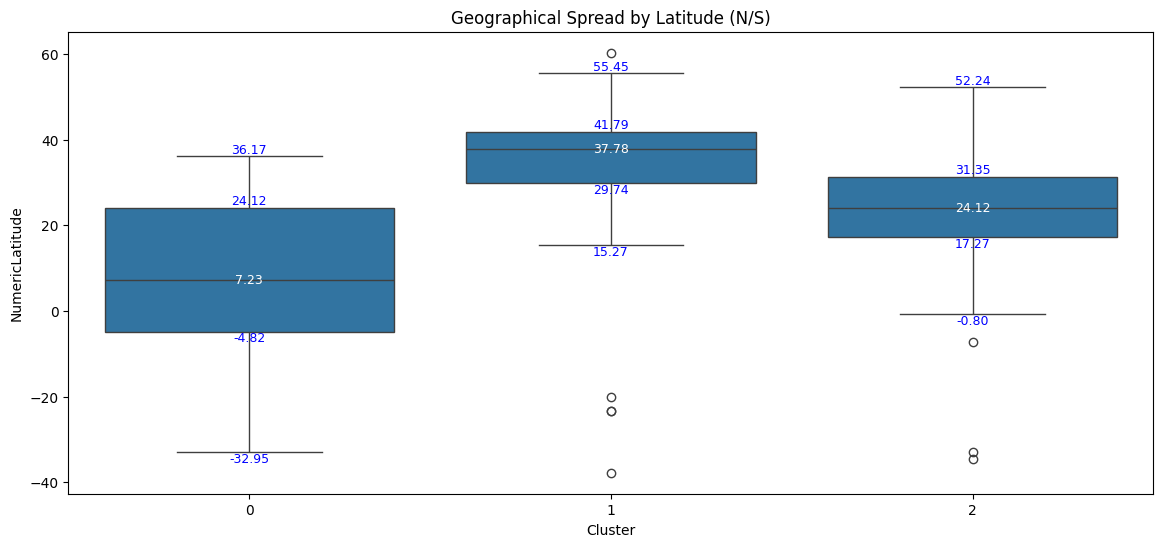

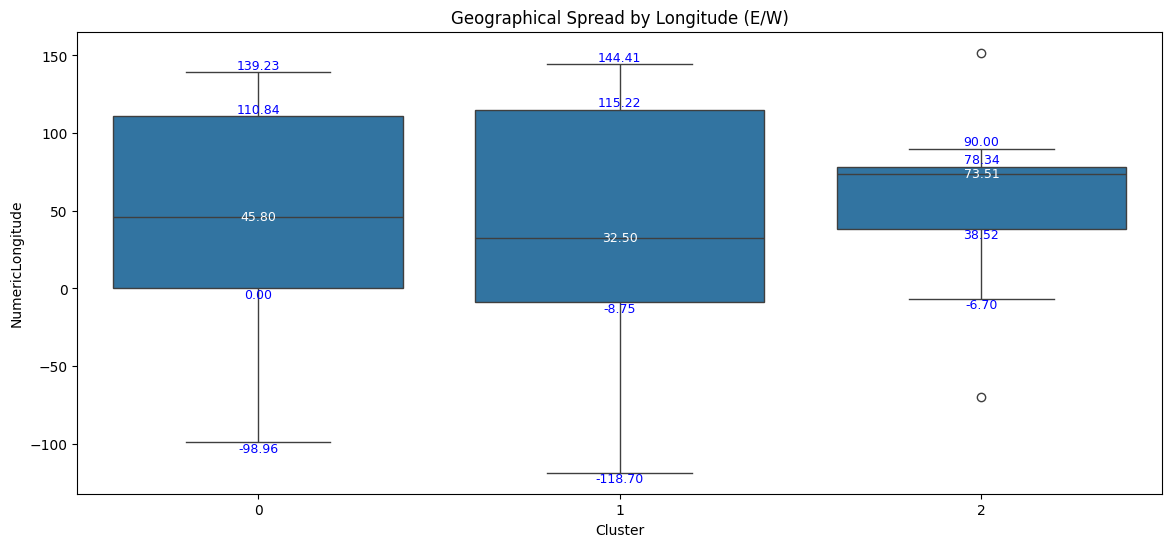

In [20]:
# Latitude
plt.figure(figsize=(14, 6))
sns.boxplot(x='Cluster', y='NumericLatitude', data=df_kmeans)

num_clusters = df_kmeans['Cluster'].nunique()
for i in range(num_clusters):
    cluster_latitudes = df_kmeans[df_kmeans['Cluster'] == i]['NumericLatitude']
    percentiles = np.percentile(cluster_latitudes, [25, 50, 75])  # Q1, Median, Q3
    lower_whisker = np.min(cluster_latitudes[cluster_latitudes >= percentiles[0] - 1.5*(percentiles[2]-percentiles[0])])
    upper_whisker = np.max(cluster_latitudes[cluster_latitudes <= percentiles[2] + 1.5*(percentiles[2]-percentiles[0])])
    
    plt.text(i, lower_whisker, f'{lower_whisker:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[0], f'{percentiles[0]:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[1], f'{percentiles[1]:.2f}', ha='center', va='center', fontsize=9, color='white')
    plt.text(i, percentiles[2], f'{percentiles[2]:.2f}', ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(i, upper_whisker, f'{upper_whisker:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

plt.title('Geographical Spread by Latitude (N/S)')
plt.ylabel('NumericLatitude')
plt.xlabel('Cluster')
plt.show()

# Longitude
plt.figure(figsize=(14, 6))
sns.boxplot(x='Cluster', y='NumericLongitude', data=df_kmeans)
for i in range(num_clusters):
    cluster_Longitudes = df_kmeans[df_kmeans['Cluster'] == i]['NumericLongitude']
    percentiles = np.percentile(cluster_Longitudes, [25, 50, 75])  # Q1, Median, Q3
    lower_whisker = np.min(cluster_Longitudes[cluster_Longitudes >= percentiles[0] - 1.5*(percentiles[2]-percentiles[0])])
    upper_whisker = np.max(cluster_Longitudes[cluster_Longitudes <= percentiles[2] + 1.5*(percentiles[2]-percentiles[0])])
    
    # Placing text annotations for percentiles
    plt.text(i, lower_whisker, f'{lower_whisker:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[0], f'{percentiles[0]:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[1], f'{percentiles[1]:.2f}', ha='center', va='center', fontsize=9, color='white')
    plt.text(i, percentiles[2], f'{percentiles[2]:.2f}', ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(i, upper_whisker, f'{upper_whisker:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

plt.title('Geographical Spread by Longitude (E/W)')
plt.ylabel('NumericLongitude')
plt.xlabel('Cluster')
plt.show()